# Deep-Learning enhanced Dynamic Mode Decomposition
In this notebook we're going to reproduce the DMD presented in **[1]**. We will also validate the implementation against one of the examples in the paper.

## Model architecture and idea
There's a huge literature on how to improve datasets to enhance DMD results, a few very simple examples are centering and normalizing. However none of this strategies is general (i.e. works for any problem) and works out of the box (i.e. it needs some further understanding of the problem and of the DMD algorithm).

The idea from which DLDMD stems is pretty simple: we use an encoder/decoder architecture to find a mapping to some optimal latent space. In between acts the DMD, which receives in input latent snapshot, thus (theoretically) providing better results.

To summarize the architecture:
1. MLP: Encode the input
2. DMD: Apply the DMD algorithm
3. MLP: Decode the DMD output

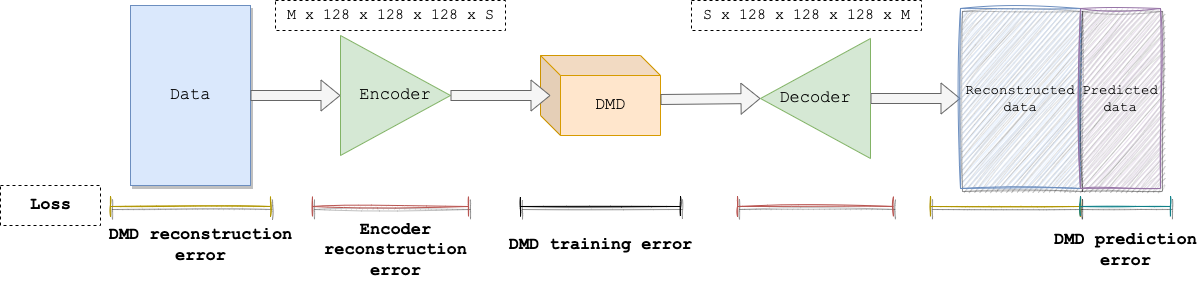

Clearly all the components should work perfectly good in order to provide reasonable results. Any bad-trained component will make the whole pipeline fail miserably.

## Implementation
First of all we import a few modules.

In [1]:
%matplotlib inline

import time
import os
import logging
from functools import wraps
from copy import deepcopy

import numpy as np
import torch
import torch.optim as optim
from torch.nn.functional import mse_loss
from torch.utils.data import DataLoader
from torch.nn import Sequential, ReLU, Linear, Module

from pydmd import DMD

logger = logging.getLogger()
logger.setLevel(logging.WARNING)

We prepare a special decorator `@timer` which decorates function for which we'd like to know the execution time. We're going to use this in the `DLDMD` class further below.

In [2]:
def timer(func):
    @wraps(func)
    def timed_func(*args, **kwargs):
        start = time.time_ns()
        val = func(*args, **kwargs)
        dt_ms = (time.time_ns() - start) / 1_000_000
        return dt_ms, val

    return timed_func

Finally we define the `DLDMD` class (obvisouly extending `torch.nn.Module`). The compulsory parameters are:
+ The encoder module;
+ A DMD instance from PyDMD
+ The decoder module;

In addition, the user may provide:
+ 4 training weights for the different outputs given by DMD (reconstruction, prediction, phase space, encoding accuracy);
+ An optimizer (by default we use `Adam`);
+ A `dict` of optimizer parameters;
+ The number of snapshots to be predicted (and therefore to train upon).

`DLDMD` provides methods for the forward pass (`forward`) which specializes in `train_step` and `eval_step`. It handles the computation of the loss function, and model-saving as well.

In [3]:
class DLDMD(Module):
    def __init__(
        self,
        encoder,
        dmd,
        decoder,
        encoding_weight,
        reconstruction_weight,
        prediction_weight,
        phase_space_weight,
        optimizer=optim.Adam,
        optimizer_kwargs={"lr": 1.0e-3, "weight_decay": 1.0e-9},
        n_prediction_snapshots=1,
        eval_on_cpu=True,
    ):
        super().__init__()

        self._encoder = encoder
        self._decoder = decoder
        
        self._optimizer = optimizer(self.parameters(), **optimizer_kwargs)
        logger.info(f"Optimizer: {self._optimizer}")

        self._encoding_weight = encoding_weight
        self._reconstruction_weight = reconstruction_weight
        self._prediction_weight = prediction_weight
        self._phase_space_weight = phase_space_weight

        self._eval_on_cpu = eval_on_cpu

        logger.info(f"DMD instance: {type(dmd)}")
        self._dmd = dmd
        # a copy of dmd to be used only for evaluation
        self._eval_dmd = deepcopy(dmd)

        self._n_prediction_snapshots = n_prediction_snapshots
        logger.info(
            f"DMD will predict {n_prediction_snapshots} snapshots during training."
        )

        logger.info("----- DLDMD children -----")
        logger.info(tuple(self.children()))

    def forward(self, input):
        if input.ndim == 2:
            input = input[None]

        logger.debug(f"Input shape: {input.shape}")
        encoded_input = self._encoder(input.swapaxes(-1, -2)).swapaxes(-1, -2)
        logger.debug(f"Encoded input shape: {encoded_input.shape}")
        self._dmd.fit(encoded_input, batch=True)
        self._dmd.dmd_time["tend"] = (
            self._dmd.original_time["tend"] + self._n_prediction_snapshots
        )

        encoded_output = self._dmd.reconstructed_data.swapaxes(-1, -2)
        logger.debug(f"Encoded output shape: {encoded_output.shape}")

        if not torch.is_complex(input):
            old_dtype = encoded_output.dtype
            encoded_output = encoded_output.real
            logger.debug(
                f"Removing complex part from output_immersion: {old_dtype} to {encoded_output.dtype}"
            )
        if encoded_output.dtype != input.dtype:
            logger.debug(
                f"Casting output_immersion dtype from {encoded_output.dtype} to {input.dtype}"
            )
            encoded_output = encoded_output.to(dtype=input.dtype)

        return self._decoder(encoded_output).swapaxes(-1, -2)

    def _dmd_training_snapshots(self, snapshots):
        if self._n_prediction_snapshots > 0:
            return snapshots[..., :, : -self._n_prediction_snapshots]
        return snapshots

    def _prediction_snapshots(self, snapshots):
        if self._n_prediction_snapshots > 0:
            return snapshots[..., :, -self._n_prediction_snapshots :]
        return torch.zeros(0)

    def _compute_loss(self, output, input):
        logger.debug(f"Input shape: {input.shape}")
        logger.debug(f"Output shape: {output.shape}")

        decoder_loss = mse_loss(self._decoder(self._encoder(input.swapaxes(-1,-2))).swapaxes(-1,-2), input)

        batched_psp = self._dmd.operator.phase_space_prediction
        psp_loss = torch.linalg.matrix_norm(batched_psp).sum()

        reconstruction_loss = mse_loss(
            self._dmd_training_snapshots(output),
            self._dmd_training_snapshots(input),
        )

        prediction_loss = mse_loss(
            self._prediction_snapshots(output),
            self._prediction_snapshots(input),
        )

        return (
            self._encoding_weight * decoder_loss
            + self._phase_space_weight * psp_loss
            + self._reconstruction_weight * reconstruction_loss
            + self._prediction_weight * prediction_loss
        )

    @timer
    def train_step(self, loader):
        self.train()
        loss_sum = 0.0
        for i, minibatch in enumerate(loader):
            self._optimizer.zero_grad()
            output = self(self._dmd_training_snapshots(minibatch))
            loss = self._compute_loss(output, minibatch)
            loss.backward()
            self._optimizer.step()
            loss_sum += loss.item()
        return loss_sum / (i + 1)

    @timer
    def eval_step(self, loader):
        self.eval()
        loss_sum = 0.0
        prediction_sum = 0.0
        for i, minibatch in enumerate(loader):
            output = self(self._dmd_training_snapshots(minibatch))
            loss = self._compute_loss(output, minibatch)
            loss_sum += loss.item()

            prediction_sum += mse_loss(
                self._prediction_snapshots(output),
                self._prediction_snapshots(minibatch),
            ).item()

        loss_avg = loss_sum / (i + 1)
        return loss_avg, prediction_sum / (i + 1)

    def save_model(self, label="dldmd"):
        temp = self._dmd
        self._dmd = self._eval_dmd
        torch.save(self, label + ".pl")
        self._dmd = temp

    @staticmethod
    def load_model_for_eval(label="dldmd", eval_on_cpu=True):
        map_location = (
            "cpu"
            if eval_on_cpu or not torch.cuda.is_available()
            else "cuda"
        )
        model = torch.load(label + ".pl", map_location=map_location)
        model.eval()
        return model

The training loop receives a blank `dldmd` instance and two 3D tensors `training_data` and `test_data` (the first dimension is dedicated to batching). Other parameters can be used as well to tune the training (number of `epochs`, `batch_size`, etc).

In [4]:
def train_dldmd(dldmd, training_data, test_data,
                batch_size=256, epochs=1000, acceptable_loss=0, print_prediction_loss=True, 
                print_every=True, label="dldmd", eval_on_cpu=True):
    
    train_dataloader = DataLoader(
        training_data, batch_size=batch_size, shuffle=True
    )
    test_dataloader = DataLoader(
        test_data, batch_size=batch_size, shuffle=True
    )

    train_loss_arr = []
    eval_loss_arr = []
    
    if torch.cuda.is_available():
        dldmd.to("cuda", dtype=training_data.dtype)
    else:
        dldmd.to(dtype=training_data.dtype)

    for epoch in range(1, epochs + 1):
        training_time, train_loss = dldmd.train_step(train_dataloader)
        train_loss_arr.append(train_loss)

        model_label = f"{label}_e{epoch}"
        dldmd.save_model(model_label)
        eval_model = DLDMD.load_model_for_eval(model_label, eval_on_cpu)

        eval = eval_model.eval_step(test_dataloader)
        eval_time, (eval_loss, prediction_loss) = eval

        if not eval_loss_arr or min(eval_loss_arr) > eval_loss:
            dldmd.save_model(f"{label}_best")
        eval_loss_arr.append(eval_loss)

        if epoch % print_every == 0:
            logger.info(
                f"[{epoch}] loss: {eval_loss:.7f}, train_time: {training_time:.2f} ms, eval_time: {eval_time:.2f} ms"
            )
            if print_prediction_loss:
                logger.info(
                    f"[{epoch}] prediction loss: {prediction_loss:.7f}"
                )
        else:
            os.remove(model_label + ".pl")

        if eval_loss < acceptable_loss:
            break

    np.save(f"{label}_train_loss.npy", train_loss_arr)
    np.save(f"{label}_eval_loss.npy", eval_loss_arr)
    
    return dldmd

We also define a very simple MLP. We're going to use an hardcoded 3-layers perceptron like **[1]**, but there's no constraint on the number of layers. The parameters required by the MLP are the input and output dimensions.

In [5]:
class MLP(Module):
    def __init__(self, input_size, output_size, hidden_layer_size):
        super().__init__()
        self.layers = Sequential(
            Linear(input_size, hidden_layer_size),
            ReLU(),
            Linear(hidden_layer_size, hidden_layer_size),
            ReLU(),
            Linear(hidden_layer_size, output_size),
        )

    def forward(self, x):
        return self.layers(x)

## Data
First of all we import a special module which we're going to use to generate data to feed DMD.

In [6]:
from pathlib import Path
import os
import sys

sys.path.append(str(Path(os.getcwd()).parent) + "/src")
from data import data_maker_duffing

We're going to reproduce one of the cases discussed in **[1]** in order to validate our implementation of DLDMD. In particular we chose the following differential equation, also known as *Duffing oscillator*:
$$\Large
\begin{cases}
\frac{dx}{dt} = y\\
\frac{dy}{dt} = x - x^3
\end{cases}
$$
By integrating this equation with numerical methods we can get a truthful dataset which we may use for DMD analysis. Generating random initial conditions (which have surprisingly different behaviors in the interval $[-1,1]$) enables using DLDMD to train our Deep Learning model.

In [7]:
training_count = 10000
eval_count = 3000
eval_on_cpu = False

data = data_maker_duffing(
    x_lower1=-1,
    x_upper1=1,
    x_lower2=-1,
    x_upper2=1,
    n_ic=training_count + eval_count,
    dt=0.05,
    tf=20,
)
data = torch.from_numpy(data).swapaxes(-1, -2)[:, :-1]
training_data = data[: training_count]
test_data = data[training_count :]
del data

if torch.cuda.is_available():
    device = torch.device("cuda")
    training_data = training_data.to(device)
    if not eval_on_cpu:
        test_data = test_data.to(device)

## Allocating and training the model
First of all we define the encoder/decoder networks, along with their hyperparameters:

In [8]:
hidden = 128
immersion_size = 2

encoder = MLP(training_data.shape[-2], immersion_size, hidden)
decoder = MLP(immersion_size, training_data.shape[-2], hidden)

Then we allocate the DMD instance (we use the standard variant like **[1]**) and the `DLDMD` model:

In [9]:
dmd = DMD(svd_rank=-1)
dldmd = DLDMD(
    encoder=encoder,
    dmd=dmd,
    decoder=decoder,
    encoding_weight=10,
    reconstruction_weight=1,
    prediction_weight=1,
    phase_space_weight=0,
    n_prediction_snapshots=5
)

Finally we can train the model:
```python
train_dldmd(dldmd, training_data, test_data, epochs=1000, eval_on_cpu=eval_on_cpu)
```
<u>We won't run it here since it would take too long.</u> Instead, we're going to load a pre-trained model.

## Loss function
The loss function employed for training the model is comprised of multiple components, each one having its own weight:
- Regularization
- Encoder/Decoder (MSE against the original data)
- DLDMD reconstruction accuracy
- DLDMD prediction accuracy
- DMD accuracy (computed on internal quantities in PyDMD)

We plot below the loss status over the training, which was comprised of 750 epochs, 10 000 training samples and 3 000 testing samples:

[font_manager.py:1350 -     _findfont_cached() ] findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
[font_manager.py:1350 -     _findfont_cached() ] findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
[font_manager.py:1350 -     _findfont_cached() ] findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


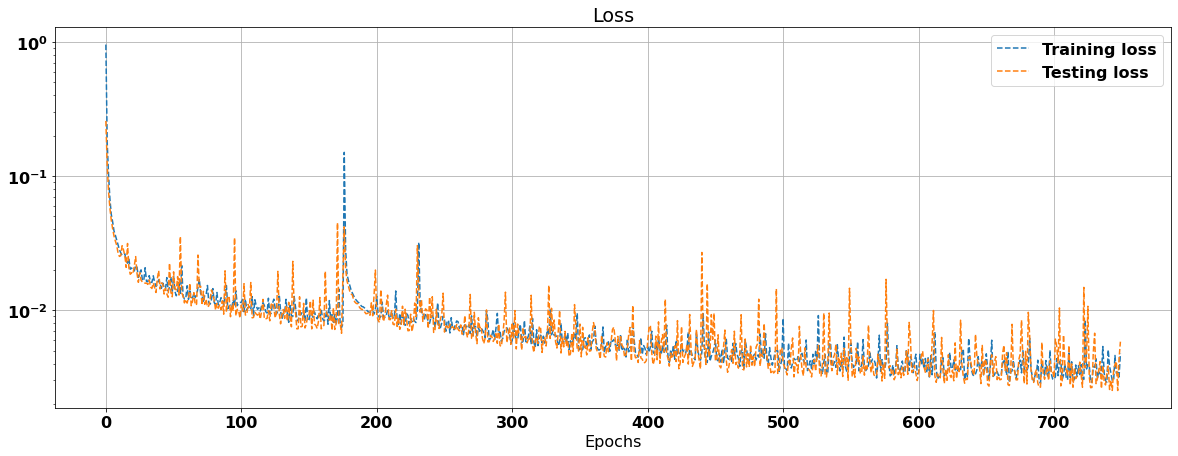

In [10]:
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}
matplotlib.rc('font', **font)

train_loss = np.load("data/duffing_train_loss.npy")
testing_loss = np.load("data/duffing_eval_loss.npy")

plt.figure(figsize=(20,7))
plt.plot(train_loss, '--', label='Training loss')
plt.plot(testing_loss, '--', label='Testing loss')

plt.grid()
plt.xlabel('Epochs')
plt.legend()
plt.yscale('log')
plt.title('Loss')

plt.show()

## Evaluation
First of all we load a trained model; we also create a DMD instance for comparison, and in order to evaluate the performance on unseen time instants we're going to advance by 100 time instants in future.

In [11]:
eval_dldmd = DLDMD.load_model_for_eval(label='data/duffing_best')

dmd_eval = DMD(svd_rank=-1)

prediction = 100
dt = 0.05

We then generate a few samples of (unseen) data for evaluation:

In [12]:
eval_data = data_maker_duffing(
    x_lower1=-1,
    x_upper1=1,
    x_lower2=-1,
    x_upper2=1,
    n_ic=30,
    dt=dt,
    tf=50,
)
eval_data = torch.from_numpy(eval_data).swapaxes(-1,-2)
eval_data.shape

torch.Size([30, 2, 1001])

Finally we can fit the standard DMD:

In [13]:
dmd_eval.fit(eval_data[..., :-prediction], batch=True)
dmd_eval.dmd_time['tend'] += prediction
dmd_rec = np.array(dmd_eval.reconstructed_data.real)

[snapshots.py:40 -             __init__() ] Snapshots: torch.Size([30, 2, 901]), snapshot shape: torch.Size([2, 901])


.. and the DL-enhanced DMD:

In [14]:
eval_dldmd._n_prediction_snapshots = prediction
dldmd_rec = np.array(eval_dldmd(eval_data[..., :-prediction]).detach())

[snapshots.py:40 -             __init__() ] Snapshots: torch.Size([30, 3, 901]), snapshot shape: torch.Size([3, 901])


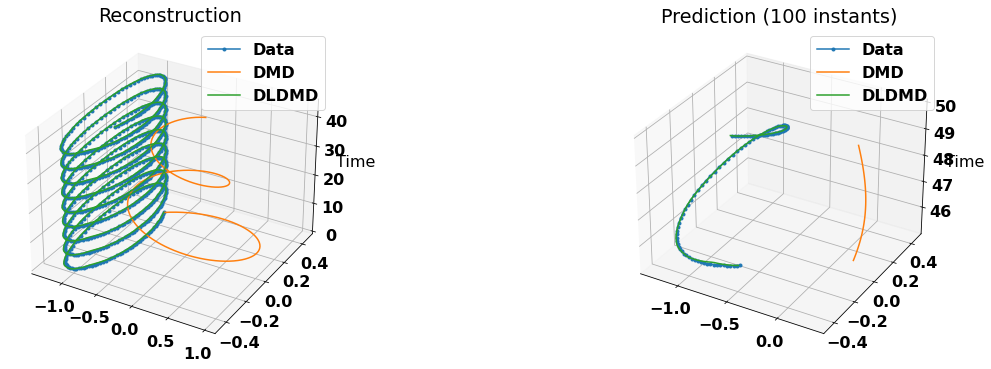

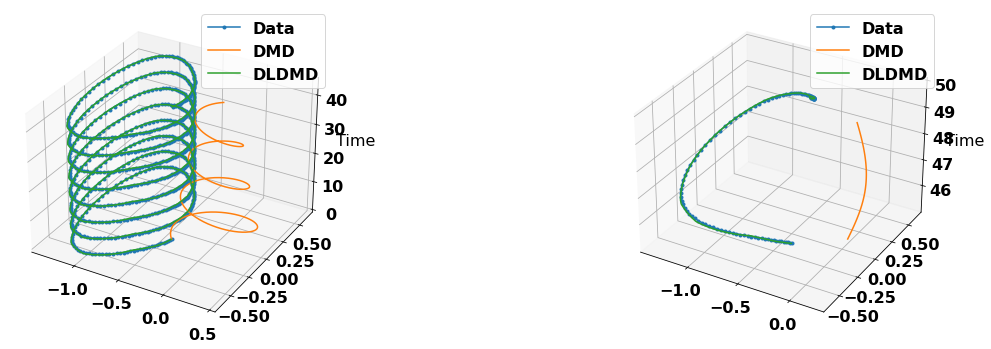

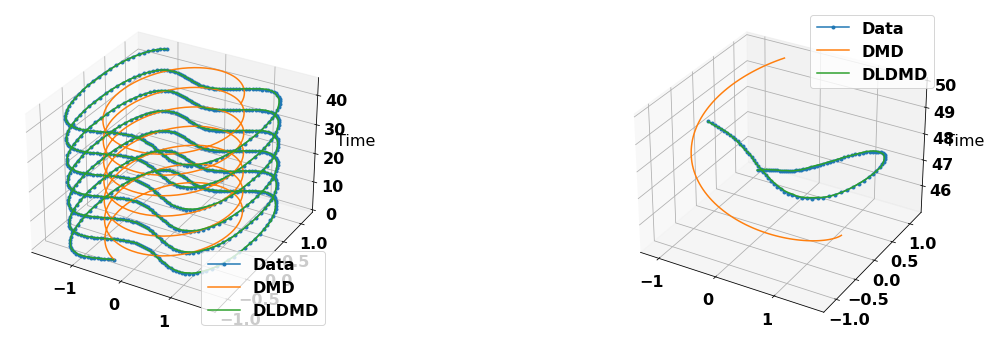

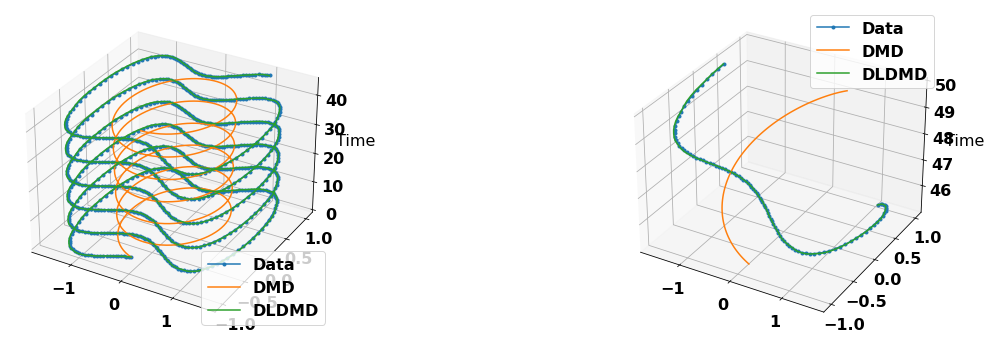

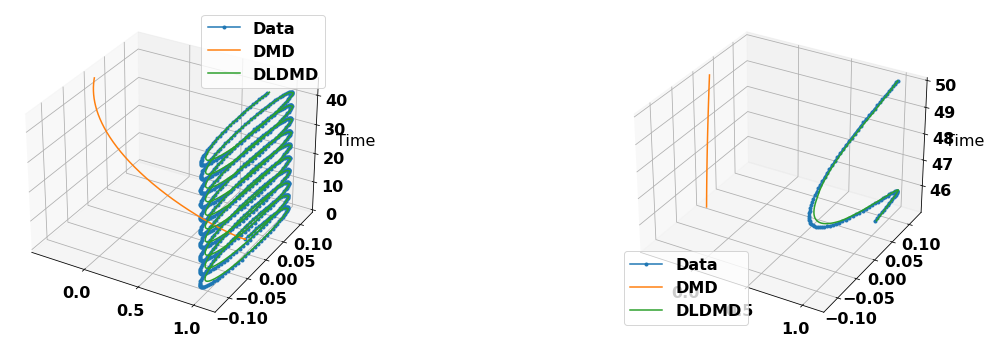

In [15]:
eval_data_np = np.array(eval_data)
time = np.arange(eval_data.shape[-1]) * dt

for i in range(5):
    plt.figure(figsize=(20,6))
    
    ax = plt.subplot(1,2,1, projection='3d')
    plt.plot(eval_data_np[i,0,:-prediction], eval_data_np[i,1,:-prediction], time[:-prediction], '.-', label='Data')
    plt.plot(dmd_rec[i,0,:-prediction], dmd_rec[i,1,:-prediction], time[:-prediction], label='DMD')
    plt.plot(dldmd_rec[i,0,:-prediction], dldmd_rec[i,1,:-prediction], time[:-prediction], label='DLDMD')
    plt.legend()
    ax.set_zlabel('Time')
    if i == 0:
        plt.title('Reconstruction')
    
    ax = plt.subplot(1,2,2, projection='3d')
    plt.plot(eval_data_np[i,0,-prediction:], eval_data_np[i,1,-prediction:], time[-prediction:], '.-', label='Data')
    plt.plot(dmd_rec[i,0,-prediction:], dmd_rec[i,1,-prediction:], time[-prediction:], label='DMD')
    plt.plot(dldmd_rec[i,0,-prediction:], dldmd_rec[i,1,-prediction:], time[-prediction:], label='DLDMD')
    plt.legend()
    ax.set_zlabel('Time')
    if i == 0:
        plt.title(f'Prediction ({prediction} instants)')
    
    plt.show()

We use the evaluation dataset we built to compute a rough error estimate of the prediction error on the 100 predicted time instants:

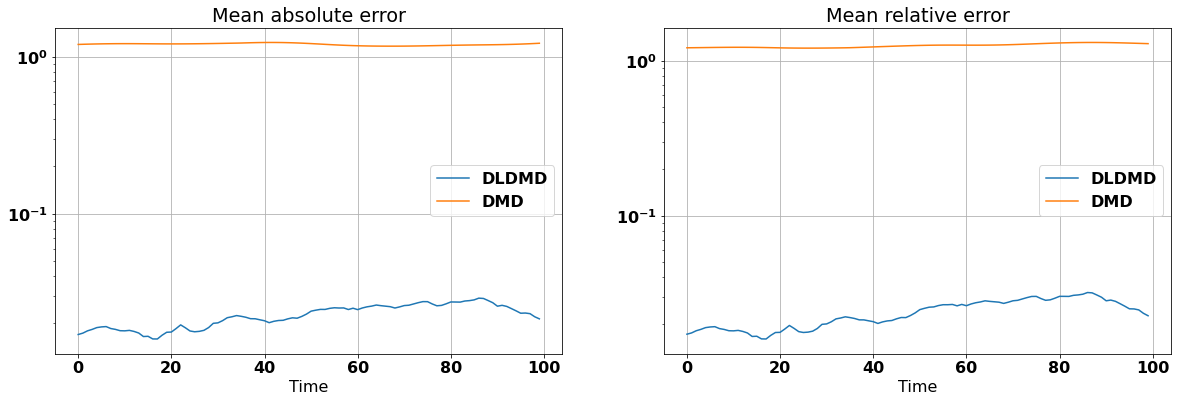

In [16]:
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
dldmd_abs_err = np.linalg.norm(eval_data_np[..., -prediction:] - dldmd_rec[..., -prediction:], axis=-2)
mean_dldmd_abs_err = dldmd_abs_err.mean(axis=0)
plt.plot(mean_dldmd_abs_err, label='DLDMD')

dmd_abs_err = np.linalg.norm(eval_data_np[..., -prediction:] - dmd_rec[..., -prediction:], axis=-2)
mean_dmd_abs_err = dmd_abs_err.mean(axis=0)
plt.plot(mean_dmd_abs_err, label='DMD')

plt.xlabel('Time')
plt.yscale('log')
plt.grid()
plt.legend()
plt.title('Mean absolute error')

plt.subplot(1,2,2)

nrm_factor = np.linalg.norm(eval_data_np[..., -prediction:], axis=-2).mean(axis=0)

mean_dldmd_rel_err = np.abs(mean_dldmd_abs_err / nrm_factor)
plt.plot(mean_dldmd_rel_err, label='DLDMD')
mean_dmd_rel_err = np.abs(mean_dmd_abs_err / nrm_factor)
plt.plot(mean_dmd_rel_err, label='DMD')

plt.xlabel('Time')
plt.yscale('log')
plt.grid()
plt.legend()
plt.title('Mean relative error')

plt.show()

## Encoder/Decoder
We briefly have a look at what the encoder/decoder pair is doing:

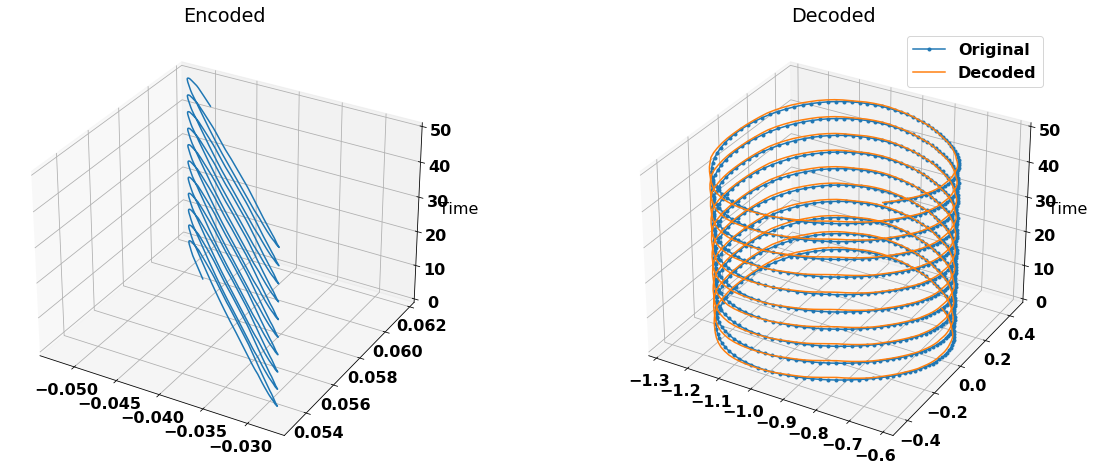

In [17]:
plt.figure(figsize=(20,8))

encoded = eval_dldmd._encoder(eval_data.swapaxes(-1, -2)).swapaxes(-1, -2)
encoded_np = np.array(encoded.detach())

ax = plt.subplot(1,2,1, projection='3d')
plt.plot(encoded_np[0,0], encoded_np[0,1], time)
plt.title('Encoded')
ax.set_zlabel('Time')

decoded = eval_dldmd._decoder(encoded.swapaxes(-1,-2)).swapaxes(-1,-2)
decoded_np = np.array(decoded.detach())

ax = plt.subplot(1,2,2, projection='3d')
plt.plot(eval_data_np[0,0], eval_data_np[0,1], time, '.-', label='Original')
plt.plot(decoded_np[0,0], decoded_np[0,1], time, label='Decoded')
plt.title('Decoded')
plt.legend()
ax.set_zlabel('Time')

plt.show()

It looks like the encoder/decoder pair embedded in `DLDMD` found an optimal latent space which is more easily learnable for the DMD algorithm.

# References
**[1]** _Alford-Lago, Daniel J., et al. "Deep learning enhanced dynamic mode decomposition." Chaos: An Interdisciplinary Journal of Nonlinear Science 32.3 (2022): 033116._

**[2]** _Goodfellow, Ian, Yoshua Bengio, and Aaron Courville. Deep learning. MIT press, 2016._